<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="https://raw.githubusercontent.com/jupyter/nature-demo/master/images/jupyter-logo.png" width="150px" style="display: inline-block; margin-top: 65px;">
<a href="http://linkedin.com/in/corypruce/"><img src="http://blackbaseball.com/wp-content/uploads/2012/03/linkedin-logo.png" width="150px" class="pull-right" style="display: inline-block; margin: 0px;"></a>
</div>

# Cory Pruce
## Rolling windows over streams of numbers <br/>

### Problem Statement

https://discuss.leetcode.com/topic/21691/rolling-average-and-rolling-maximum-over-two-different-window-size

Given a stream of numbers, write code to calculate the rolling average and rolling maximum over two different window sizes. We provide an illustrative example below. It illustrates the expected output for window sizes of 3 and 5. For your solution please implement a solution that uses window sizes of 3 and 20.

*For example*, given a stream containing the following values:

[1, 2, 3, 4, 5, 6]

the following tuples would be expected, where ‘None’ indicates that a value is not available, and would be ‘NaN’ in some languages.

<div class="alert alert-success" role="alert" style="margin: 10px">
In the following, I will calculate the <b>rolling average</b> as the <b>simple moving average</b>:
</div>

$$\begin{align}\hat{x}_{SMA} = \frac{x_M + x_{M-1} + \cdots + x_{M-(n-1)}}{n}
& = \frac{1}{n}\sum_{i=0}^{n-1}x_{M-i}\end{align}$$

where $n$ is the number of elements in the window and $M$ is the index of the window. This yields:

$$\hat{x}_{SMA,i} = \hat{x}_{SMA,i-1} + \frac{x_{M}}{n} - \frac{x_{M-1}}{n}$$

for each shift of the window from $i-1$ to $i$.

<div class="alert alert-success" role="alert" style="margin: 10px">
a <b>cumulative moving average</b> as:
</div>

$$\begin{align}\hat{x}_{CMA} = \frac{x_{0} + \cdots + x_{i-1}}{i}
& = \frac{1}{n}\sum_{i=0}^{N-1}x_{i}\end{align}$$

<div class="alert alert-success" role="alert" style="margin: 10px">
and the <b>rolling maximum</b> as:
</div>

$$\begin{align}\hat{x}_{SMM} = \frac{\max(x_M, x_{M-1}, \cdots, x_{M-(n-1)})}{n}\end{align}$$

<div class="alert alert-success" role="alert" style="margin: 10px">
<p><b>win_size</b> makes <b>average</b> or <b>max</b> return <b>None</b> if the number of elements traversed thus far is <b>less than</b> the window size (win_size).

<p><i>For example</i>, <br/>
average([1,2], win_size=3) -> None <br/>
average([1,2,3], win_size=3) -> 2</p>
</div>

(None, None, None, None) <- <b>(average([1], win_size=3), max([1], win_size=3), average([1], win_size=5), max([1], win_size=5))</b> <br/>
(None, None, None, None) <- <b>(average([1,2], win_size=3), max([1,2], win_size=3), average([1,2], win_size=5), max([1,2], win_size=5))</b> <br/>
(2, 3, None, None) <- <b>(average([1,2,3], win_size=3), max([1,2,3], win_size=3), average([1,2,3], win_size=5), max([1,2,3], win_size=5))</b> <br/>
(3, 4, None, None) <- <b>(average([2,3,4], win_size=3), max([2,3,4], win_size=3), average([1,2,3,4], win_size=5), max([1,2,3,4], win_size=5))</b> <br/>
(4, 5, 3, 5) <- <b>(average([3,4,5], win_size=3), max([3,4,5], win_size=3), average([1,2,3,4,5], win_size=5), max([1,2,3,4,5], win_size=5))</b><br/>
(5, 6, 4, 6) <- <b>(average([4,5,6], win_size=3), max([4,5,6], win_size=3), average([2,3,4,5,6], win_size=5), max([2,3,4,5,6], win_size=5))</b>

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import random as rand

Test iterator: 1 2 3 4 5 6
Win size 1: 3 --- Win size 2: 5 

(None, None, None, None)
(None, None, None, None)
(2, 3, None, None)
(3, 4, None, None)
(4, 5, 3, 5)
(5, 6, 4, 6)


<IPython.core.display.Javascript object>


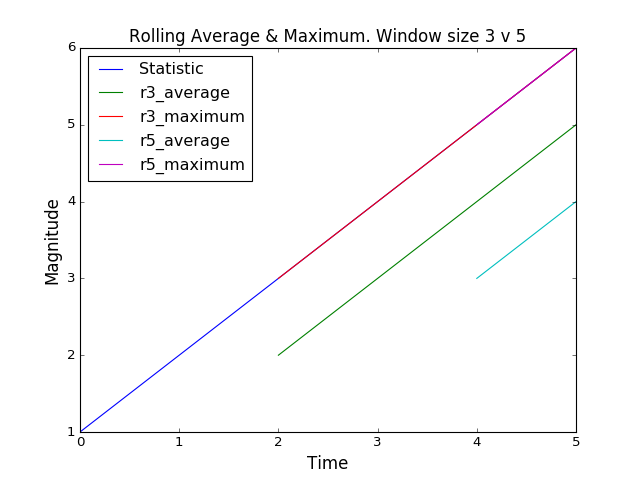

<IPython.core.display.Javascript object>


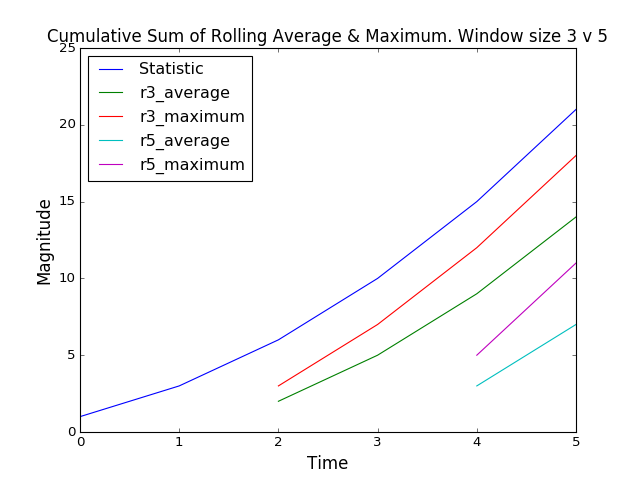

In [16]:
class RollingGenerator(object):
    
    def next_rolling_avg(self):
        """
        Produce the next simple rolling average.
        Uses the generator class's num to keep track
        of current position in iterable.
        """
         
        num = self.num+1 # covert scale from 0- to 1-
        if num < self.win_size:
            # wait until window size is spanned
            return None
        
        # find window indices
        start = num-self.win_size
        end = num
        
        if self.has_begun:
            # use constant time operations for subsequent rounds
            s = self.win_sum
            s -= self.stat_iter[start-1]
            s += self.stat_iter[end-1]
            self.win_sum = s
        else:
            # only sum all the window elements on the first round
            # to bootstrap the constant time operations
            stat_slice = self.stat_iter[start:end]
            s = sum(stat_slice)
            self.win_sum = s
            self.has_begun = True
                
        if self.roll_method == 'simple':        
            self.cur_win_avg = s // self.win_size
            
        return self.cur_win_avg      
         
    def next_rolling_max(self):
        """
        Produce the next rolling maximum.
        Uses the generator class's num to keep track
        of current position in iterable.
        """
                
        num = self.num+1 # covert scale from 0- to 1-
        if num < self.win_size:
            # wait until window size is spanned
            return None
        
        # find window indices
        start = num-self.win_size
        end = num
        
        if self.cur_win_max == float('-inf'):
            # once window size is spanned, initialize the cur max
            self.cur_win_max = max(self.stat_iter[:end])
            return self.cur_win_max
        
        cur = self.stat_iter[end-1]
        if cur > self.cur_win_max:
            # if the next element is greater than the max, it becomes the
            # current max regardless
            self.cur_win_max = cur
        elif self.cur_win_max == self.stat_iter[start-1]:
            # if the cur max is the last element to leave, find new max.
            # safe for first round since the first if condition will be true.
            self.cur_win_max = max(self.stat_iter[start:end])
        # else current window max remains the same
        
        return self.cur_win_max

    def next(self):
        """
        Produce the next rolling average or max.
        Uses the generator class's num to keep track
        of current position in iterable.
        Produces the rolling average and then the 
        rolling max in order to decompose yield easily.
        """
        
        num = self.num
        if num < self.n:
            metric_name = self.metrics[self.cur_metric]
            if metric_name == 'avg':
                r_val = self.next_rolling_avg()
            elif metric_name == 'max':
                r_val = self.next_rolling_max()
                
            self.cur_metric = (self.cur_metric+1) % self.n_metrics
            if self.cur_metric == 0:
                self.num+=1
            yield r_val
    
    def __init__(self, stat_iter, window_size, metrics=['avg', 'max'], roll_method='simple'):
        self.num, self.n, self.win_size, self.win_sum = 0, len(stat_iter), window_size, 0 
        self.stat_iter, self.metrics = stat_iter, metrics
        self.cur_metric, self.n_metrics = 0, len(metrics)
        self.roll_method = roll_method # roll method is set as blueprints for allowing other avg's
        self.cur_win_max = self.cur_win_avg = float('-inf')
        self.has_begun = False
        
        
def plot_rolling(base_iter, win1_avgs, win1_maxs, win2_avgs, win2_maxs, win1_size, win2_size):
    """
    Produce the direct line graph and cumulative sum
    line graph in order to demonstrate correctness and
    facilitate intuition. Once started, a metric continues,
    implying that any overlap can be viewed as sharing the 
    same magnitude at that instance in time.
    @param: base_iter -> input set of statistics
    @param: win1_avgs -> set of window size 1 rolling avgs
    @param: win1_maxs -> set of window size 1 rolling maxs
    @param: win2_avgs -> set of window size 2 rolling avgs
    @param: win2_maxs -> set of window size 2 rolling maxs
    @param: win1_size -> first window size
    @param: win2_size -> second window size
    """
    
    str_ws1 = str(win1_size)
    str_ws2 = str(win2_size)
    win_1_avg_key = ''.join(['r', str_ws1, '_average'])  
    win_1_max_key = ''.join(['r', str_ws1, '_maximum'])
    win_2_avg_key = ''.join(['r', str_ws2, '_average'])
    win_2_max_key = ''.join(['r', str_ws2, '_maximum'])
    
    d = { 'Statistic': np.array(base_iter),
           win_1_avg_key: np.array(win1_avgs),
           win_1_max_key: np.array(win1_maxs),
           win_2_avg_key: np.array(win2_avgs),
           win_2_max_key: np.array(win2_maxs)
        }
    
    df = pd.DataFrame(d)
    dfcs = df.cumsum()
    df.plot() # linestyle='steps' -> using line graphs since steps are difficult to read
    plt.title("Rolling Average & Maximum. Window size " + str_ws1 + 
              " v " + str_ws2, fontsize=15)
    plt.xlabel("Time", fontsize=15)
    plt.ylabel("Magnitude", fontsize=15)
    plt.legend(loc='best')
    
    dfcs.plot() # linestyle='steps' -> using line graphs since steps are difficult to read
    plt.title("Cumulative Sum of Rolling Average & Maximum. Window size " + 
              str_ws1 + " v " + str_ws2, fontsize=15)
    plt.xlabel("Time", fontsize=15)
    plt.ylabel("Magnitude", fontsize=15)
    plt.legend(loc='best')
    
def test_two_windows(num, win_size_1, win_size_2, use_rand=False):
    """
    Produce a test to illustrate difference in 
    rolling average and maximum with two window
    sizes.
    @param: num -> range to choose from
    @param: win_size_1 -> first window size
    @param: win_size_2 -> second window size
    @param: use_rand -> allows for random input iterable
    """
    
    if win_size_1 > num or win_size_2 > num:
        print("please keep input proper")
    else:
        if use_rand:
            example_iter = [rand.randrange(num) for _i in range(num)]
        else:
            example_iter = range(1, num+1)
        print("Test iterator:", *example_iter)
        print("Win size 1:", win_size_1, "--- Win size 2:", win_size_2, "\n")
        win_size_1_rg = RollingGenerator(example_iter, win_size_1)
        win_size_2_rg = RollingGenerator(example_iter, win_size_2)
    
        r1_avgs, r1_maxs, r2_avgs, r2_maxs = [], [], [], []
    
        for _i in example_iter:
            r1_avg = win_size_1_rg.next()
            r1_max = win_size_1_rg.next()
            r2_avg = win_size_2_rg.next()
            r2_max = win_size_2_rg.next()
            t = (*r1_avg, *r1_max, *r2_avg, *r2_max)
            print(t, sep='\n')
            r1_avgs.append(t[0])
            r1_maxs.append(t[1])
            r2_avgs.append(t[2])
            r2_maxs.append(t[3])
        plot_rolling(example_iter, r1_avgs, r1_maxs, r2_avgs, r2_maxs, win_size_1, win_size_2)

NUM = 6 
WIN_SIZE_1 = 3
WIN_SIZE_2 = 5 
test_two_windows(NUM, WIN_SIZE_1, WIN_SIZE_2)

# (None, None, None, None)
# (None, None, None, None)
# (2, 3, None, None)
# (3, 4, None, None)
# (4, 5, 3, 5)
# (5, 6, 4, 6)

<div class="alert alert-success" role="alert" style="margin: 10px">
From the problem statement, the rolling average seems to be the simple moving average (SMA). In order to allow extensibility, I enable the RollingGenerator to take a <i>roll_method</i>. This is <i>simple</i> by default. However, the intention is that other methods of taking the moving average can be defined. 

In the given example, the iterable happens to be monotonically increasing and happens to have overlapping values for lengths of time.
</div>

Test iterator: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
Win size 1: 3 --- Win size 2: 20 

(None, None, None, None)
(None, None, None, None)
(2, 3, None, None)
(3, 4, None, None)
(4, 5, None, None)
(5, 6, None, None)
(6, 7, None, None)
(7, 8, None, None)
(8, 9, None, None)
(9, 10, None, None)
(10, 11, None, None)
(11, 12, None, None)
(12, 13, None, None)
(13, 14, None, None)
(14, 15, None, None)
(15, 16, None, None)
(16, 17, None, None)
(17, 18, None, None)
(18, 19, None, None)
(19, 20, 10, 20)
(20, 21, 11, 21)


<IPython.core.display.Javascript object>


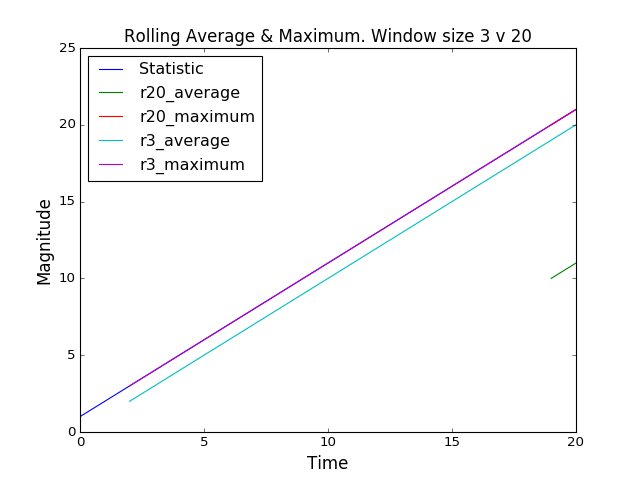

<IPython.core.display.Javascript object>


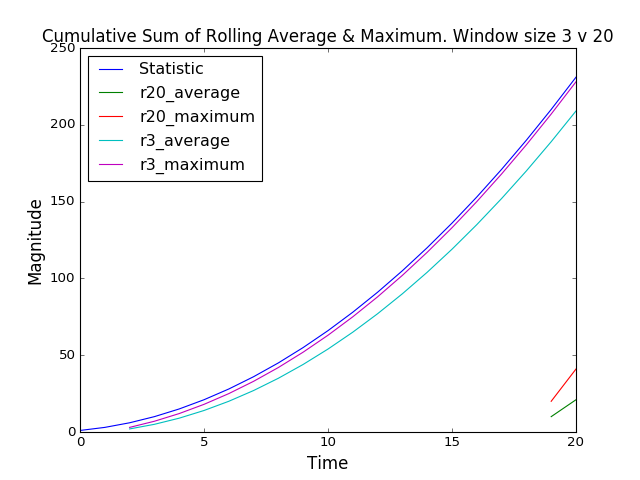

In [10]:
NUM = 21
WIN_SIZE_1 = 3
WIN_SIZE_2 = 20 
test_two_windows(NUM, WIN_SIZE_1, WIN_SIZE_2)

<div class="alert alert-success" role="alert" style="margin: 10px">
For the problem asked to be solved (window sizes 3 and 20), the simple rolling averages and maximums follow the same trend as the example problem (window sizes 3 and 5) if the same type of monotonically increasing iterable is used.

Let's test the algorithms with some randomized input iterables.
</div>

Test iterator: 19 7 10 4 15 0 8 4 12 11 14 1 4 2 17 7 15 4 3 18 16
Win size 1: 3 --- Win size 2: 20 

(None, None, None, None)
(None, None, None, None)
(12, 19, None, None)
(7, 10, None, None)
(9, 15, None, None)
(6, 15, None, None)
(7, 15, None, None)
(4, 8, None, None)
(8, 12, None, None)
(9, 12, None, None)
(12, 14, None, None)
(8, 14, None, None)
(6, 14, None, None)
(2, 4, None, None)
(7, 17, None, None)
(8, 17, None, None)
(13, 17, None, None)
(8, 15, None, None)
(7, 15, None, None)
(8, 18, 8, 19)
(12, 18, 8, 18)


<IPython.core.display.Javascript object>


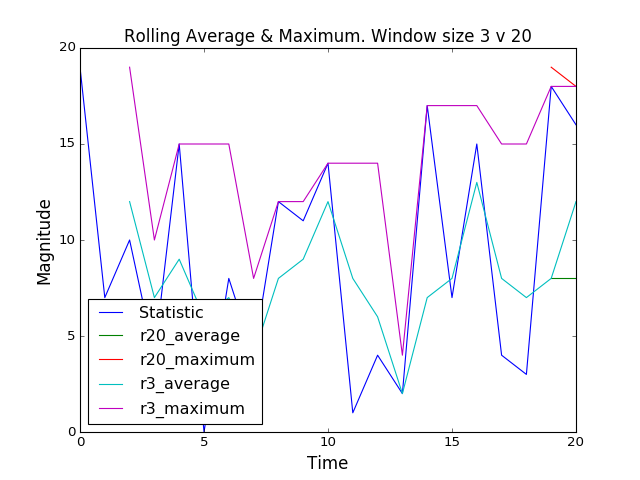

<IPython.core.display.Javascript object>


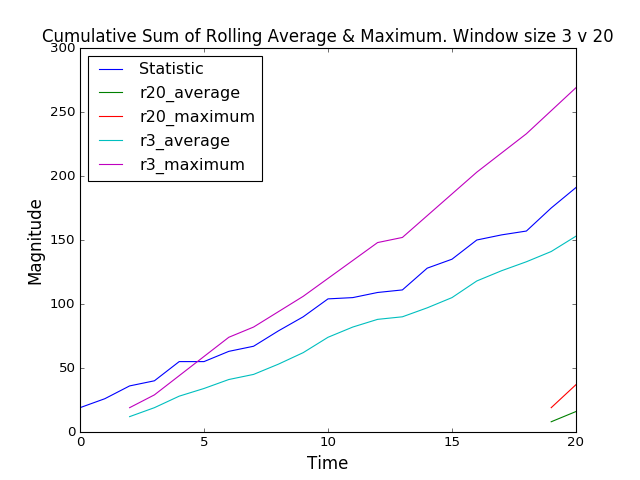

In [17]:
NUM = 21 
WIN_SIZE_1 = 3
WIN_SIZE_2 = 20
test_two_windows(NUM, WIN_SIZE_1, WIN_SIZE_2, use_rand=True)

Test iterator: 14 8 3 13 16 6 6 19 19 15 11 7 15 9 14 1 1 3 7 3 11
Win size 1: 3 --- Win size 2: 5 

(None, None, None, None)
(None, None, None, None)
(8, 14, None, None)
(8, 13, None, None)
(10, 16, 10, 16)
(11, 16, 9, 16)
(9, 16, 8, 16)
(10, 19, 12, 19)
(14, 19, 13, 19)
(17, 19, 13, 19)
(15, 19, 14, 19)
(11, 15, 14, 19)
(11, 15, 13, 19)
(10, 15, 11, 15)
(12, 15, 11, 15)
(8, 14, 9, 15)
(5, 14, 8, 15)
(1, 3, 5, 14)
(3, 7, 5, 14)
(4, 7, 3, 7)
(7, 11, 5, 11)


<IPython.core.display.Javascript object>


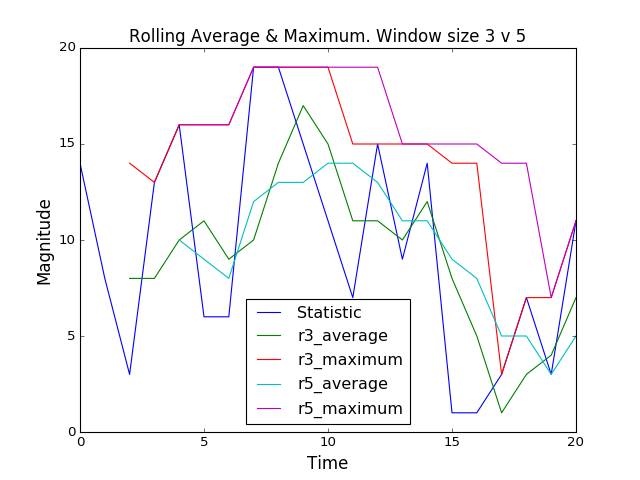

<IPython.core.display.Javascript object>


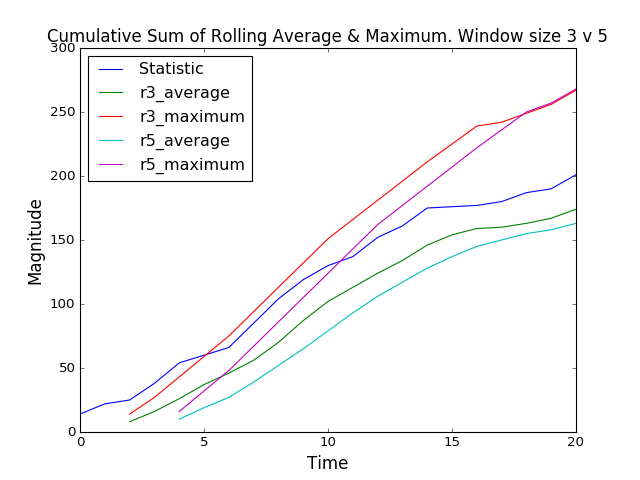

In [18]:
NUM = 21 
WIN_SIZE_1 = 3
WIN_SIZE_2 = 5 
test_two_windows(NUM, WIN_SIZE_1, WIN_SIZE_2, use_rand=True)

<div class="alert alert-success" role="alert" style="margin: 10px">
The algorithms seem to generalize well to less structured input iterables. Moreover, the randomized input iterables do a better job at illustrating the movements of the window averages and maximums in the first line graph.
</div>

<b>Your Response</b>
Your response should consist of source code that will solve the problem described above. In addition, please provide a write-up discussing the following topics in your response: <br/>

 * Any assumptions you made <br/>
     <div class="alert alert-success" role="alert" style="margin: 10px">
         <ul> 
         <li> Based on the example test case, I assumed that only integers should be considered, though real values should not affect the algorithms. </li>
         <li> Based on the example test case, I assumed that the simple moving average is being used and that there are no suprise deviations. </li>
         <li> I also assumed that no negative values would be inputted. This shouldn't be difficult to incorporate into the algorithm as I used a "minimum" number <i>float('-inf')</i>, which should handle any number above it (all representable numbers). However, I feel additional testing should be done to verify correctness with negatives. </li>
         </ul>
     </div>
 * The space and time complexity of your algorithm and the trade-offs you made between the two <br/>
     <div class="alert alert-success" role="alert" style="margin: 10px">
         <ul> 
         <li> Addressed in Efficiency of the implementation </li>
         </ul>
     </div>
 * Improvements you would make given more time to work on the problem <br/>
     <div class="alert alert-success" role="alert" style="margin: 10px">
         <ul> 
         <li> Generalize the algorithm to handle negative values robustly. </li>
         <li> Look into more insights that could be made. </li>
         <li> Support other types of rolling average, ie. exponential. </li>
         <li> Make the class even more extensible by taking more metrics (median) and other types of moving averages (cumulative). I have laid some initial foundations as to how I would do this. However, I would change some things up. Instead of having a set of if-elif conditions, I would covert the <i>metric_function</i> and <i>roll_method</i> matches to dictionary lookups. </li>
         </ul>
     </div>
 * Please discuss any change in your approach if instead of 3 and 20 elements, we want to calculate over the last 10,000 or 1 Million elements <br/>
     <div class="alert alert-success" role="alert" style="margin: 10px">
         <ul> 
         <li> My approach would likely not change as I tried to minimize time and space complexity and consider scaling. The memory footprint for the algorithms is constant, ignoring the original iterable. </li>
         <li> I would likely look into other optimizations. For example, there could be an optimized algorithm on the web, some Python magic can be worked in, and parallelization can be utilized. </li>
         </ul>
     </div>
 * Please discuss how you would extend your code to handle finding the median over these window sizes in addition to the mean and max <br/>
     <div class="alert alert-success" role="alert" style="margin: 10px">
         <ul> 
         <li> I would create the extensibility as described in the second bullet point above and define a function which would roughly be based on the rolling average by shifting, seeing if even or odd, and finding the "halfway" point accordingly. This would create a median entry for each window. Additionally, the generator "loop" would also be extend to consider the length of the suggested metrics list. </li>
         </ul>
     </div>

**Your solution will be judged on**
   1. <b>Correctness</b>: 
       <div class="alert alert-success" role="alert" style="margin: 10px">
         Given the example code looks for the simple moving average, this code presents the proper formatting for two requested window sizes: 3 and 5 for the given example as well as 3 and 20 for the test. Additionally, randomized input iterables were tested.
       </div>
   2. <b>Clarity of the code and documentation</b>: 
       <div class="alert alert-success" role="alert" style="margin: 10px">
         Code has been commented for clarification, notebook used for organization, graphs used for visualization.
       </div>
   3. <b>Efficiency of the implementation</b>:
       <div class="alert alert-success" role="alert" style="margin: 10px">
         <ul> 
         <li> <b>Rolling average</b>: The simple rolling average implementation uses constant <i>O(1)</i> space complexity, as I keep track of the current window sum as opposed to a the list of integers. The time complexity is linear <i>O(n)</i> since we must traverse the whole iterable and view each element at least once. Keeping track of the window sum is a compact and fast way to calculate the average for each window. This way, the algorithm doesn't need to do a linear search for each window shift, but rather only for the initial, bootstrap average when the current position in the iterable is equal to the window size. As for similar work, I came across this (https://www.codeproject.com/articles/17860/a-simple-moving-average-algorithm) after I had finished the assignment. Regarding complexity improvement, I feel the worst-case can not be brought down anymore classes (constant for space-complexity and linear for time-complexity) since each element needs to be seen at least once. </li>
         <li> <b>Rolling maximum</b>: The rolling maximum algorithm could be made faster by keeping track of a sorted list of the last <i>win_size</i> elements. However, this likely would not scale well and a linear search for placement of the next element would still have to be performed. Thus, the algorithm that I employ is constant time when the next element is the max in the window or the existing max is still the max in the window. The worst-case scenario of one yield is <i>O(m)</i> (where <i>m</i> = window size) for choosing the next max when the previous max is the next element to be removed from the window. Thus for <i>n</i> elements, the worst-case time complexity is <i>O(m</i>\*<i>n)</i>, or <i>O(n)</i> if <i>m</i> is considered a constant. The space-complexity for this approach is <i>O(1)</i> since only the current max is kept track of. Regarding complexity improvement, I believe that the rolling maximum problem, like the rolling average, cannot be reduced to any lower worst-case classes since each element needs to be viewed at least once.</li>
         </ul>
     </div>
   4. <b>Extensibility</b>: 
       <div class="alert alert-success" role="alert" style="margin: 10px">
As addressed in previous points above, the class and test function were made to simply support different configurations. An easy addition to the class could be to allow a set of metric names, which could be mapped to existing functions that would add the metric values to the produced tuple. This has been started and would involve creating a dictionary that maps metric names to the metric functions.
</div>
       